# Classifying Satellite Images
In this notebook, we will finally try to classify potential buildings in satellite images. We will start by doing template matching to pick out areas that are potentially buildings. Then we will use some segmentation techniques to pinpoint the locations of these building proposals. Finally, we will compute color histograms of the local area of the building proposals and use these color histograms to classify the proposals as either roofs or some other class.

## Template matching
First, let's display an image that we're going to try to classify.

In [1]:
from IPython import display
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
imageDir = '../images/'
testDir = imageDir + 'test_images/'
test1Fn = testDir + 'test1.png'
templateDir = imageDir + 'templates/'
template1Fn = templateDir + 'template1.png'

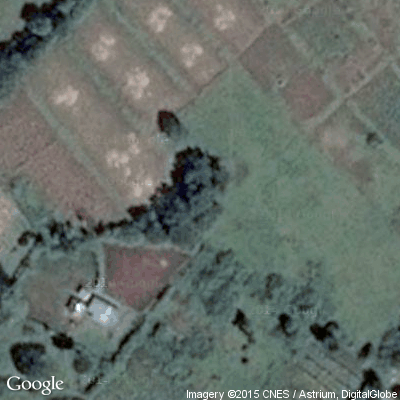

In [3]:
# Displaying test image 1
display.Image(filename=test1Fn)

In [4]:
# Displaying template 1
display.Image(filename=template1Fn)

We can use one of the template matching functions that we wrote earlier to template match and threshold our image. This should give us some candidate locations for buildings.

In [5]:
from utils import *
import numpy as np
import cv2

In [6]:
# Match template and threshold result
test1_matched = match_template(test1Fn, template1Fn)
threshold = 0.1
test1_thresholded = np.copy(test1_matched)
test1_thresholded[np.where(test1_matched > threshold)] = 0
test1_thresholded[np.where(test1_matched <= threshold)] = 1

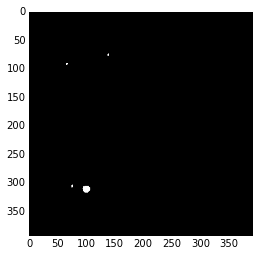

In [7]:
# Show thresholded test image 1
plt.imshow(test1_thresholded, cmap=plt.cm.Greys_r)

## Image segmentation
Now we want to use some of the techniques that we learned about image segmentation to pinpoint the locations of our candidate buildings within the image. Once we know the center points of these candidates, we can extract local image patches to calculate color histograms.

In [8]:
import skimage.measure

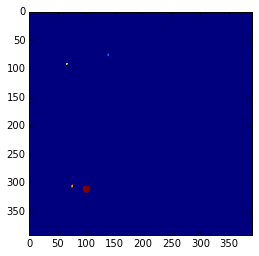

In [9]:
# Marker labeling
markers, numMarkers = skimage.measure.label(test1_thresholded,\
                                            return_num=True)
plt.imshow(markers)

Now that we have labeled each image segment with a different integer, we can calculate the center of each "blob":

In [10]:
# Find centers of each building candidate
candidate_center = np.zeros((numMarkers-1, 2))
for i in range(numMarkers-1):
    candidate_location = np.where(markers==i+1)
    candidate_center[i,:] = np.array([candidate_location[0].mean(),\
                                candidate_location[1].mean()]).round()

In [19]:
candidate_center

array([[  76.,  138.],
       [  92.,   66.],
       [ 305.,   75.],
       [ 310.,  100.]])

### Candidate extraction
In the previous step, we calculated the centroids of each of our candidate roofs within the satellite image. Now we want to extract local image patches around these centroids to use for color histogram classification.

In [11]:
from color_histograms import *

In [71]:
# For each candidate centroid, extract image patch
test1 = cv2.imread(test1Fn)
radius = 5
candidate_hists = np.zeros((numMarkers-1, 48))
# Calculate color histograms for each candidate image patch
for i in range(numMarkers-1):
    row = candidate_center[i,0]
    col = candidate_center[i,1]
    patch = test1[row-radius:row+radius+1, col-radius:col+radius+1, :]
    candidate_hists[i,:] = calc_color_hist(patch).flatten()

## Candidate classification
Now, we've calculated the color histograms for each of our candidate image patches. The last thing left to do is to classify them as roof or non-roof using k-nearest neighbors.

First we need to import the data from our training examples:

In [72]:
imageDataFn = '../data/imageData.csv'
# Using function for importing data from csv
hists, labels, le = import_image_data(imageDataFn)

['dirt' 'roof' 'vegetation' 'water']
Got class labels for 280 training data points.
Got feature vector for 280 training data points.


In [73]:
from sklearn import neighbors

In [74]:
# Create and fit a nearest-neighbor classifier
n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on all 280 training observations
knn.fit(hists, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [75]:
# Predict labels for test set
candidate_predictions = knn.predict(candidate_hists)
candidate_probs = knn.predict_proba(candidate_hists)
# Comparing predictions to actual labels for test set
candidate_labels = le.inverse_transform(candidate_predictions)

We've predicted classes for each of the candidate building locations in our satellite image. Now we want to visualize our predictions so that we can see how well our algorithm did.

In [115]:
from PIL import Image

In [117]:
PILtest1 = Image.open(test1Fn)
convertedtest1 = PILtest1.convert('P')

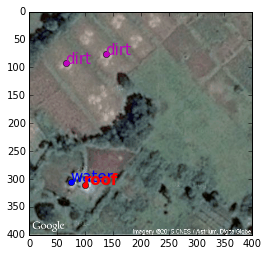

In [120]:
# Colors for each class
colors = ['m', 'r', 'v', 'b']
weights = ['normal', 'bold', 'normal', 'normal']
# Plot classification results on original image
plt.figure()
plt.imshow(convertedtest1)
for i in range(numMarkers-1):
    class_label = candidate_predictions[i]
    plt.plot(candidate_center[i,1], candidate_center[i,0], 'o',\
             color=colors[class_label])
    plt.text(candidate_center[i,1], candidate_center[i,0],\
             candidate_labels[i], color=colors[class_label],\
             fontsize=15, fontweight=weights[class_label])
plt.xlim(0,400)
plt.ylim(0,400)
plt.gca().invert_yaxis()

It looks like the classifier works for the this particular image with these parameters that we have so far! We should try it for a few more test images and see how it goes.

But first, let's put all the code above into a function so that we can just give it an input satellite image and it'll spit out a labeled classified image.

In [126]:
def classify_image(imageFn, templateFn, imageDataFn, threshold=0.1,\
                   radius=5, bins=16, n_neighbors=5):
    """
    This function takes in the path of an input image and classifies all
    candidate roofs in the image and plots a labeled version of the
    original image.
    :param imageFn: Filename of the input image
    :param templateFn: Filename of the template
    :param imageDataFn: Filename of csv containing training data
    :param threshold: The threshold value for template matching
    :param radius: The radius of each extracted candidate image patch
    :param bins: The number of bins to use for color histograms
    :param n_neighbors: Number of neighbors to use for knn classification
    """
    # Match template and threshold result
    matched = match_template(imageFn, templateFn)
    thresholded = np.copy(matched)
    thresholded[np.where(matched > threshold)] = 0
    thresholded[np.where(matched <= threshold)] = 1
    
    # Show thresholded image
    plt.figure()
    plt.imshow(thresholded, cmap=plt.cm.Greys_r)
    
    # Marker labeling
    markers, numMarkers = skimage.measure.label(thresholded,\
                                            return_num=True)
    plt.figure()
    plt.imshow(markers)
    
    # Find centers of each building candidate
    candidate_center = np.zeros((numMarkers-1, 2))
    for i in range(numMarkers-1):
        candidate_location = np.where(markers==i+1)
        candidate_center[i,:] = np.array([candidate_location[0].mean(),\
                                    candidate_location[1].mean()]).round()
    # For each candidate centroid, extract image patch
    image = cv2.imread(imageFn)
    candidate_hists = np.zeros((numMarkers-1, 3 * bins))
    # Calculate color histograms for each candidate image patch
    for i in range(numMarkers-1):
        row = candidate_center[i,0]
        col = candidate_center[i,1]
        patch = image[row-radius:row+radius+1, col-radius:col+radius+1, :]
        candidate_hists[i,:] = calc_color_hist(patch, bins=bins).flatten()
    
    # Using function for importing data from csv
    hists, labels, le = import_image_data(imageDataFn)
    # Create and fit a nearest-neighbor classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    # Train on all training observations
    knn.fit(hists, labels)
    
    # Predict labels for test set
    candidate_predictions = knn.predict(candidate_hists)
    candidate_probs = knn.predict_proba(candidate_hists)
    # Comparing predictions to actual labels for test set
    candidate_labels = le.inverse_transform(candidate_predictions)
    
    # Load satellite image for display
    PILimage = Image.open(imageFn)
    convertedImage = PILimage.convert('P')
    
    # Colors for each class
    colors = ['m', 'r', 'v', 'b']
    weights = ['normal', 'bold', 'normal', 'normal']
    # Plot classification results on original image
    plt.figure()
    plt.imshow(convertedImage)
    for i in range(numMarkers-1):
        class_label = candidate_predictions[i]
        plt.plot(candidate_center[i,1], candidate_center[i,0], 'o',\
                 color=colors[class_label])
        plt.text(candidate_center[i,1], candidate_center[i,0],\
                 candidate_labels[i], color=colors[class_label],\
                 fontsize=15, fontweight=weights[class_label])
    plt.xlim(0,400)
    plt.ylim(0,400)
    plt.gca().invert_yaxis()

['dirt' 'roof' 'vegetation' 'water']
Got class labels for 280 training data points.
Got feature vector for 280 training data points.


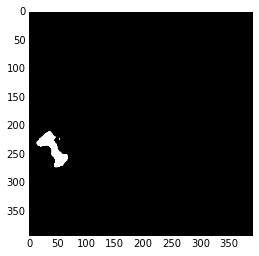

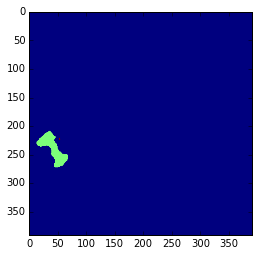

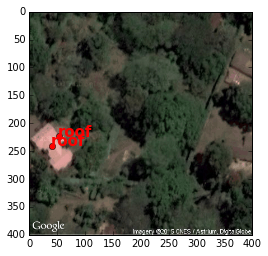

In [127]:
imageFn = testDir + 'test2.png'
templateFn = template1Fn
classify_image(imageFn, templateFn, imageDataFn)

['dirt' 'roof' 'vegetation' 'water']
Got class labels for 280 training data points.
Got feature vector for 280 training data points.


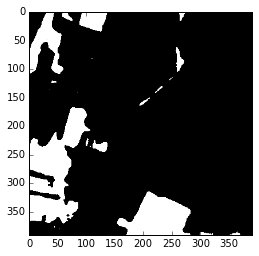

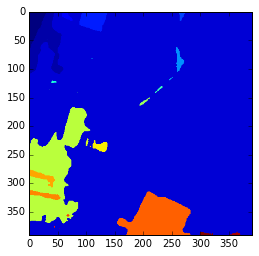

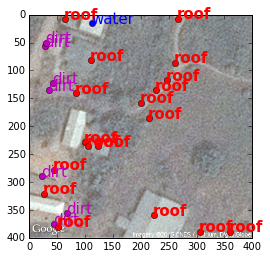

In [128]:
imageFn = testDir + 'test3.png'
templateFn = template1Fn
classify_image(imageFn, templateFn, imageDataFn)

['dirt' 'roof' 'vegetation' 'water']
Got class labels for 280 training data points.
Got feature vector for 280 training data points.


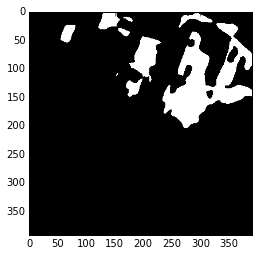

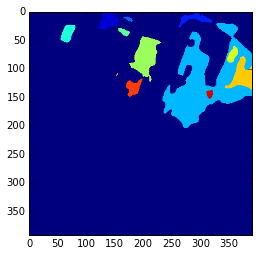

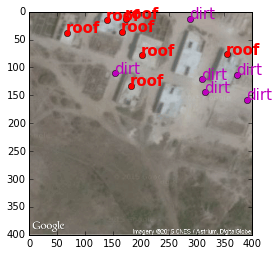

In [135]:
imageFn = testDir + 'test10.png'
templateFn = template1Fn
classify_image(imageFn, templateFn, imageDataFn)

At this point, the function randomly doesn't work for several of the test images. It also doesn't do a good job with test image 3, finding many false positives. It remains to be seen whether this can be fixed just by tweaking some of the algorithm parameters or if it is something deeper.